In [1504]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('classic')
from sklearn.decomposition import PCA
from cond_color import get_colors, plot_start, plot_end

In [1505]:
np.random.seed(42)

Loading Data

In [1506]:
data_orig = np.load('psths.npz')
X, times = data_orig['X'], data_orig['times']

# Exercise 1: Plotting raw PSTHs

In [1507]:
def plot_psths(data, timeintervals, n_rows, n_cols, n_cond):
    np.random.seed(42)
    cond = np.random.randint(low=data.shape[1], size=n_cond)

    fig, ax = plt.subplots(n_rows, n_cols, tight_layout=True, figsize=(8,8))
    for row in ax:
        n = np.random.randint(low=data.shape[0], size=1)[0]
        for c in cond:
            row.plot(timeintervals, data[n, c,:], label = 'Condition = '+str(c))
            row.set_title(f'Neuron {n}')
            row.set_xlabel('Time relative to onset of hand movement')
            row.set_ylabel('Trial-averaged spike rate (Hz)')
            row.legend(loc='lower left', prop={'size': 10})
    return

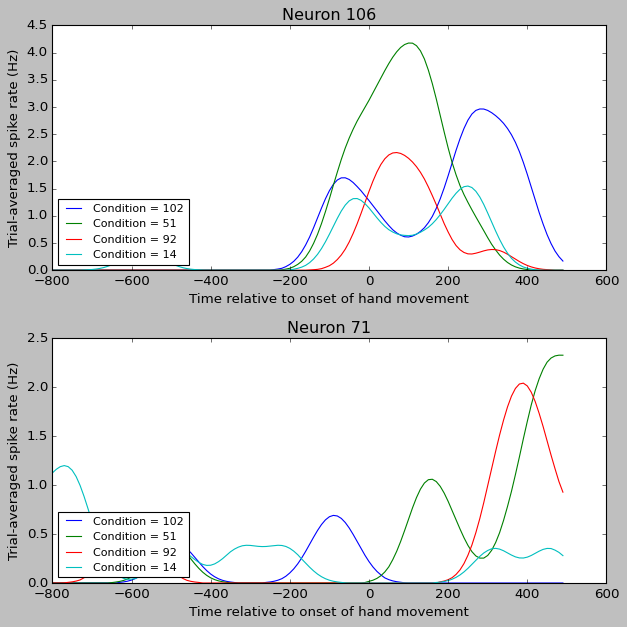

In [1508]:
plot_psths(X, times, 2, 1, 4)

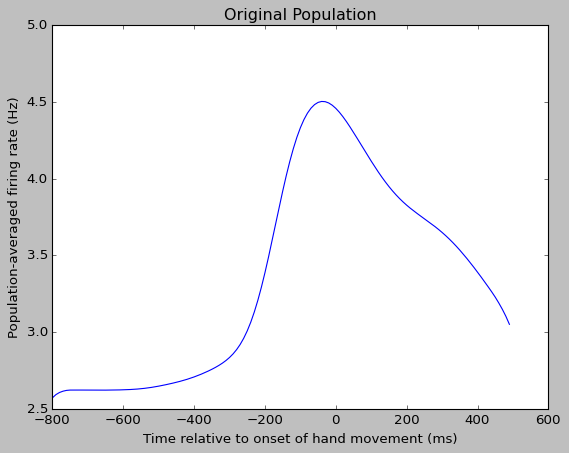

In [1509]:
pop_mean = data_orig['X'].mean(axis=(0,1))
plt.plot(times, pop_mean)
plt.title('Original Population')
plt.xlabel('Time relative to onset of hand movement (ms)')
plt.ylabel('Population-averaged firing rate (Hz)')

plt.show()

# Exercise 2: Pre-processing

## Normalisation

In [1510]:
def plot_max_hist(data):
    plt.hist(data.max(axis=(1,2)), bins=20)
    plt.title('Histogram of neuron maximum values')
    plt.ylabel('Frequency')
    plt.xlabel('Max value for a given neuron across time and conditions')

    plt.show()
    return

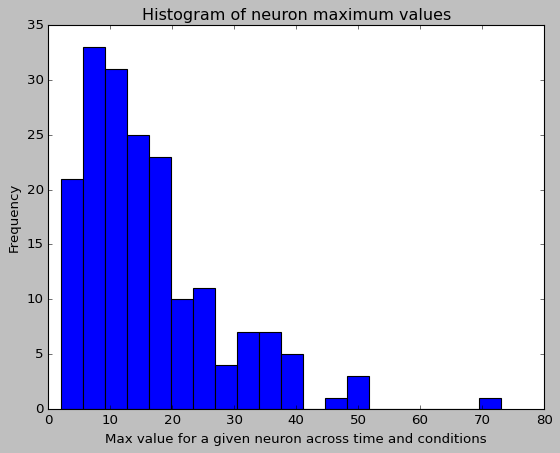

In [1511]:
plot_max_hist(X)

In [1512]:
def norm_data(data):
    a, b = data.max(axis=(1,2)), data.min(axis=(1,2))
    a, b = a.reshape(data.shape[0],1,1), b.reshape(182,1,1)
    data_normed = (data - b) / (a - b + 5 )

    return data_normed

In [1513]:
print(X.shape)

(182, 108, 130)


In [1514]:
X_norm = norm_data(X)

In [1515]:
print(X_norm.shape)

(182, 108, 130)


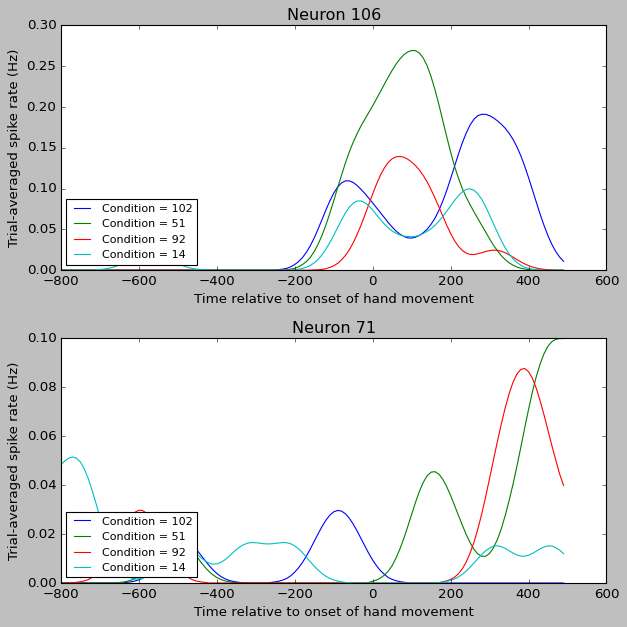

In [1516]:
plot_psths(X_norm, times, 2, 1, 4)

## Mean centering

In [1517]:
def center_data(data):
    mean = data.mean(axis=(0,2))
    print(mean.shape)
    mean = mean.reshape(1, 108, 1)
    data_centered = data - mean
    return data_centered

In [1518]:
X_norm_mean = center_data(X_norm)

(108,)


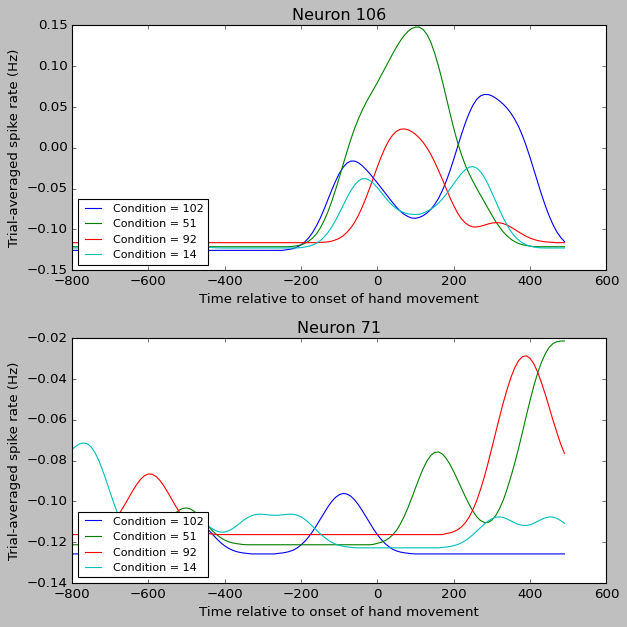

In [1519]:
plot_psths(X_norm_mean, times, 2, 1, 4)

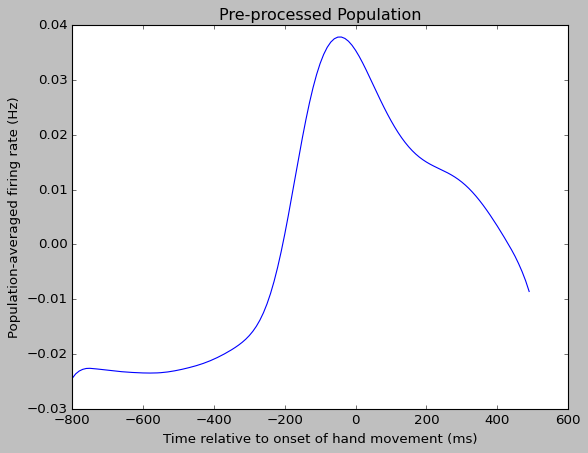

In [1520]:
pop_mean = X_norm_mean.mean(axis=(0,1))
plt.plot(times, pop_mean)
plt.title('Pre-processed Population')
plt.xlabel('Time relative to onset of hand movement (ms)')
plt.ylabel('Population-averaged firing rate (Hz)')

plt.show()

## Dimensionality reduction by PCA

In [1521]:
# times = times[65:111]

In [1522]:
X_trunc = X_norm_mean[:,:,65:111]
X = X_trunc.reshape(X_trunc.shape[0], X_trunc.shape[1]*X_trunc.shape[2])
print(X.shape)

(182, 4968)


In [1523]:
pca = PCA(n_components=12)
pca.fit(X.T)
Z = pca.transform(X.T).T
print(Z.shape)

(12, 4968)


# Plotting PC space trajectorie

In [1524]:
Z = Z.reshape(12, X_trunc.shape[1], X_trunc.shape[2])

In [1525]:
def plot_pca_psths(data1, pca_axis_1, pca_axis_2, data2=None, alpha=1):
    np.random.seed(42)
    pca_axis_1 -= 1
    pca_axis_2 -= 1
    alt_colors = [False, True]

    for index, data in enumerate([data1, data2]):
        if data is not None:
            colors = get_colors(data[pca_axis_1, :, 0], data[pca_axis_2, :, 0], alt_colors[index//2])
            for cond in range(0, data.shape[1]):
                plt.plot(data[pca_axis_1, cond, :], data[pca_axis_2, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=alpha)
                plt.title(f'PCA plot')
                plt.xlabel(f'PC - {pca_axis_1 + 1}')
                plt.ylabel(f'PC - {pca_axis_2 + 1}')
            plot_start(data[pca_axis_1, :, 0], data[pca_axis_2, :, 0], colors, markersize=50, ax=None)
            plot_end(data[pca_axis_1, :, -1], data[pca_axis_2, :, -1], colors, markersize=50, ax=None)
        else:
            pass
    plt.show()
    return

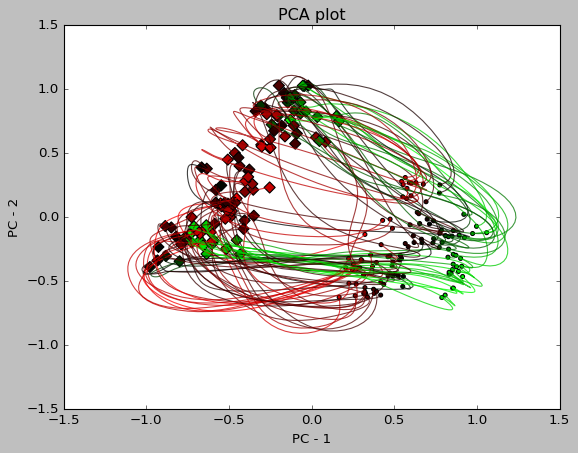

In [1526]:
plot_pca_psths(Z, 1, 2, alpha=0.75)

# Exercise 4: Finding the max. likelihood estimate for A

## Log-likelihood and its (naive) gradient

$\Delta z_{t+1} = Az_{t} + \sigma \epsilon_t$ where $\sigma=1$

$\Delta z_{t+1} = N(Az_{t},I_{12\times12})$

$P(\Delta z_{1:T-1} | z_{0:T-1}) = \prod^T_{t=0}N(Az_{t},I_{12\times12})$

$log(P(\Delta z_{1:T} | z_{0:T-1})) = \sum^T_{t=0}log(N(Az_{t},I_{12\times12}))$

$log(P(\Delta z_{1:T} | z_{0:T-1})) = \sum^T_{t=0} log(\exp(-(\Delta z_{t+1} - Az_{t})^TI_{12\times12}(\Delta z_{t+1} - Az_{t}))) + const$

$log(P(\Delta z_{1:T} | z_{0:T-1})) = -\sum^T_{t=0} (\Delta z_{t+1} - Az_{t})^TI_{12\times12}(\Delta z_{t+1} - Az_{t}) + const$

$log(P(\Delta Z | Z)) \approx -(\Delta Z - AZ)^T(\Delta Z - AZ) \approx  - Z^TA^TAZ + 2\Delta Z^T A Z$

$\frac{d}{dA}(log(P(\Delta Z | Z))) = -2 AZZ^T + 2\Delta Z Z^T$

##  Parametrising an antisymmetric

K will equal 6, the number of matrix entries above the diagonal

$M \times M = 2K + M$

$K = \frac{M(M-1)}{2}$

In [1527]:
beta = np.array([[0.0001, 1, 1, 0.0001, 1, 1]])

def create_h(m):
    k = int( (m**2 - m)/2)
    h = np.zeros((k, m, m))
    row, column = 0, 1
    for i in range(0, k):
        h[i][int(row)][int(column)], h[i][int(column)][int(row)] = 1, -1
        column += 1
        if column >= m:
            row += 1
            column = row + 1
    return h

H = create_h(4)
print(beta.shape)
print(H.shape)
print(H)

A = np.tensordot(beta, H, axes=1)
print(A)

(1, 6)
(6, 4, 4)
[[[ 0.  1.  0.  0.]
  [-1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  1.  0.]
  [ 0.  0.  0.  0.]
  [-1.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [-1.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0. -1.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0. -1.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  1.]
  [ 0.  0. -1.  0.]]]
[[[ 0.e+00  1.e-04  1.e+00  1.e+00]
  [-1.e-04  0.e+00  1.e-04  1.e+00]
  [-1.e+00 -1.e-04  0.e+00  1.e+00]
  [-1.e+00 -1.e+00 -1.e+00  0.e+00]]]


# Gradient with respect to β

$log(P(\Delta Z | Z)) \approx  - (\sum^K_{a=1}\beta_a \sum^M_{j=1}H_{a,i,j}Z_{j,n})^T(\sum^K_{a=1}\beta_a\sum^M_{j=1}H_{a,i,j}Z_{j,n}) + 2\Delta Z^T (\sum^K_{a=1}\beta_a\sum^M_{j=1}H_{a,i,j}Z_{j,n})$

$log(P(\Delta Z | Z)) \approx  - (\sum^K_{a=1}\beta_a W_{a,i,n})^T(\sum^K_{a=1}\beta_aW_{a,i,n}) + 2\Delta Z^T (\sum^K_{a=1}\beta_aW_{a,i,n}) = - (\beta W)^T(\beta W) + 2\Delta Z^T (\beta W)$

$\frac{d}{d\beta}(log(P(\Delta Z | Z))) \approx - 2\beta W^TW + 2\Delta Z^T W$

$Q = W^TW$ and $b = \Delta Z^T W$

## An antisymmetric estimate for A

Solve $ \beta = b Q^{-1}$

In [1528]:
def a_estimate(z):
    m = z.shape[0]
    z_plus, z_  = z[:,:,1:], z[:,:,:-1]
    z_plus = z_plus.reshape((m, z_plus.shape[1]*z_plus.shape[2]))
    z_ = z_.reshape((m, z_.shape[1]*z_.shape[2]))

    h = create_h(z_.shape[0])
    w = np.tensordot(h, z_, axes=1)
    q = np.tensordot(w, w, axes=([1,2],[1,2]))

    delta_z = z_plus - z_
    b = np.tensordot(delta_z, w, axes=([0,1],[1,2]))
    b = b.reshape((1,66))

    beta = b @ np.linalg.inv(q)
    a = np.tensordot(beta, h, axes=([1],[0]))
    a = a.reshape((m, m))
    return beta, a

In [1529]:
beta, A = a_estimate(Z)

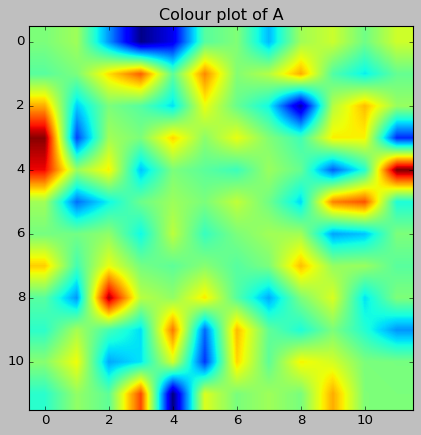

In [1530]:
plt.imshow(A)
plt.title('Colour plot of A')
plt.show()

## Test

In [1531]:
test = np.load('test.npz')
Z_test = test['Z_test']
A_test = test['A_test']

In [1532]:
beta_test_estimated, A_test_estimated = a_estimate(Z_test)

In [1533]:
A_inaccuracy = (A_test_estimated - A_test).max()
print(A_inaccuracy)

2.6940888755988546e-12


# Exercise 5: 2D projections with rotational dynamics

## A) Eigenvalues and Eigenvectors of A

In [1534]:
A_evalue, A_evector = np.linalg.eig(A)
print(A_evector)

[[ 4.22101163e-02-0.22756846j  4.22101163e-02+0.22756846j
   6.20121256e-02+0.44937841j  6.20121256e-02-0.44937841j
  -3.17489082e-01+0.25098073j -3.17489082e-01-0.25098073j
  -9.55835712e-02+0.18271709j -9.55835712e-02-0.18271709j
  -1.54411631e-01-0.00122585j -1.54411631e-01+0.00122585j
   1.80019885e-02+0.10081427j  1.80019885e-02-0.10081427j]
 [ 1.31796526e-01+0.3014407j   1.31796526e-01-0.3014407j
  -5.83462905e-02-0.13618882j -5.83462905e-02+0.13618882j
   4.24021327e-02+0.16880276j  4.24021327e-02-0.16880276j
  -1.87929296e-02+0.14980319j -1.87929296e-02-0.14980319j
  -5.10822564e-01+0.j         -5.10822564e-01-0.j
  -2.31059514e-01-0.04895732j -2.31059514e-01+0.04895732j]
 [-2.93640312e-01+0.06263381j -2.93640312e-01-0.06263381j
   2.46134517e-01+0.22338907j  2.46134517e-01-0.22338907j
   2.12939432e-04-0.296827j    2.12939432e-04+0.296827j
   1.42013081e-01+0.11830512j  1.42013081e-01-0.11830512j
  -6.54725084e-02+0.20667758j -6.54725084e-02-0.20667758j
  -2.27152391e-01-0.280

## B)

In [1535]:
def get_p(eigen_vectors, plane):
    evector_real = eigen_vectors[:,plane].real
    evector_imag = eigen_vectors[:,plane].imag
    p = np.zeros((2, 12))
    p[0, :] = evector_real/np.linalg.norm(evector_real)
    p[1, :] = evector_imag/np.linalg.norm(evector_imag)
    print(p[0, :].T @ p[1, :])
    return p

In [1536]:
P_FR = get_p(A_evector, 0)

-1.491862189340054e-16


## C)

In [1537]:
def plot_proj_psths(data1, title, data2=None, alpha=1):
    np.random.seed(42)
    alt_colors = [False, True]

    for index, data in enumerate([data1, data2]):
        if data is not None:
            colors = get_colors(data[0, :, 0], data[1, :, 0], alt_colors[index//2])
            for cond in range(0, data.shape[1]):
                plt.plot(data[0, cond, :], data[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=alpha)
                plt.title(title)
                plt.xlabel(f'Axis 1')
                plt.ylabel(f'Axis 2')
            plot_start(data[0, :, 0], data[1, :, 0], colors, markersize=50, ax=None)
            plot_end(data[0, :, -1], data[1, :, -1], colors, markersize=50, ax=None)
        else:
            pass
    plt.show()
    return

In [1538]:
Projection_FR = np.tensordot(P_FR, Z, axes=([1],[0]))
Projection_FR.shape

(2, 108, 46)

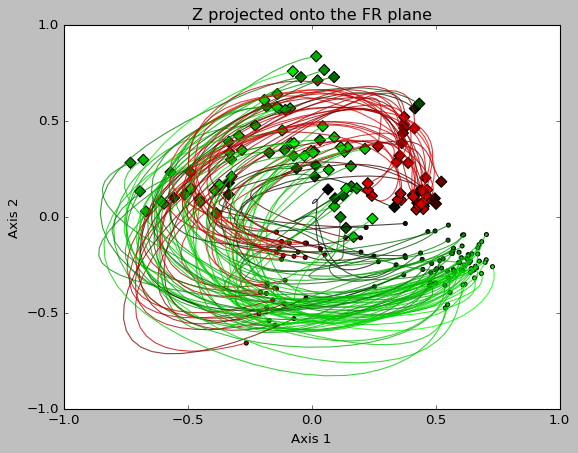

In [1539]:
plot_proj_psths(Projection_FR[:, :, 0:36], 'Z projected onto the FR plane', alpha=0.75)

## D)

In [1540]:
P_2 = get_p(A_evector, 3)
Projection_2 = np.tensordot(P_2, Z, axes=([1], [0]))
P_3 = get_p(A_evector, 5)
Projection_3 = np.tensordot(P_3, Z, axes=([1], [0]))

-2.914335439641036e-16
-1.4988010832439613e-15


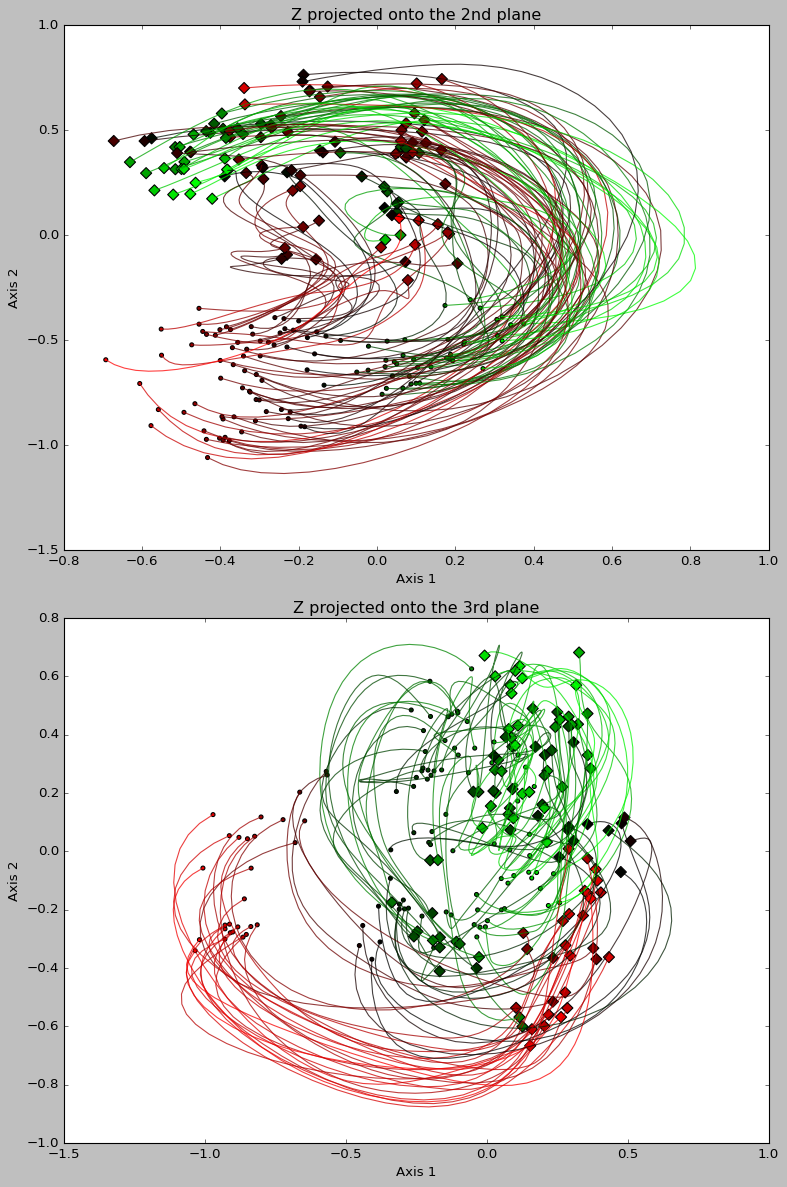

In [1541]:
fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(10,15))
data1 = Projection_2[:, :, 0:36]
data2 = Projection_3[:, :, 0:36]
colors = get_colors(data1[0, :, 0], data[1, :, 0])
for cond in range(0, data1.shape[1]):
    ax[0].plot(data1[0, cond, :], data1[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=0.75)
    ax[0].set_title('Z projected onto the 2nd plane')
    ax[0].set_xlabel(f'Axis 1')
    ax[0].set_ylabel(f'Axis 2')
plot_start(data1[0, :, 0], data1[1, :, 0], colors, markersize=50, ax=ax[0])
plot_end(data1[0, :, -1], data1[1, :, -1], colors, markersize=50, ax=ax[0])

colors = get_colors(data2[0, :, 0], data[1, :, 0])
for cond in range(0, data2.shape[1]):
    ax[1].plot(data2[0, cond, :], data2[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=0.75)
    ax[1].set_title('Z projected onto the 3rd plane')
    ax[1].set_xlabel(f'Axis 1')
    ax[1].set_ylabel(f'Axis 2')
plot_start(data2[0, :, 0], data2[1, :, 0], colors, markersize=50, ax=ax[1])
plot_end(data2[0, :, -1], data2[1, :, -1], colors, markersize=50, ax=ax[1])

# Exercise 6: Pre-movement period

In [1542]:
X_pre = X_norm_mean[:, :, :66]
X = X_pre.reshape(X_pre.shape[0], X_pre.shape[1] * X_pre.shape[2])
print(X.shape)
Z_pre = pca.transform(X.T).T
Z_pre = Z_pre.reshape(12 , X_pre.shape[1], X_pre.shape[2])
print(Z_pre.shape)
Projection_FR_pre = np.tensordot(P_FR, Z_pre, axes=([1], [0]))

(182, 7128)
(12, 108, 66)


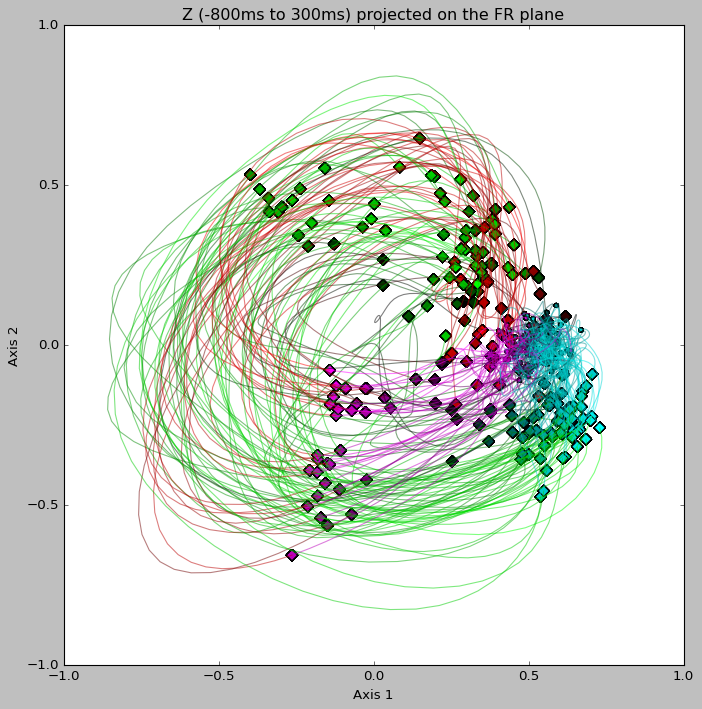

In [1543]:
plt.figure(figsize=(10, 10))
data = Projection_FR
colors = get_colors(data[0, :, 0], data[1, :, 0], alt_colors=False)
for cond in range(0, data.shape[1]):
    plt.plot(data[0, cond, :], data[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=0.5)
    plot_start(data[0, :, 0], data[1, :, 0], colors, markersize=50, ax=None)
    plot_end(data[0, :, -1], data[1, :, -1], colors, markersize=50, ax=None)

data = Projection_FR_pre
colors = get_colors(data[0, :, -1], data[1, :, -1], alt_colors=True)
for cond in range(0, data.shape[1]):
    plt.plot(data[0, cond, :], data[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=0.5)
    plot_start(data[0, :, 0], data[1, :, 0], colors, markersize=50, ax=None)
    plot_end(data[0, :, -1], data[1, :, -1], colors, markersize=50, ax=None)

plt.title('Z (-800ms to 300ms) projected on the FR plane')
plt.xlabel(f'Axis 1')
plt.ylabel(f'Axis 2')

plt.show()

# Exercise 7: Control Analysis

In [1544]:
## Load data
X_seven, times = data_orig['X'], data_orig['times']

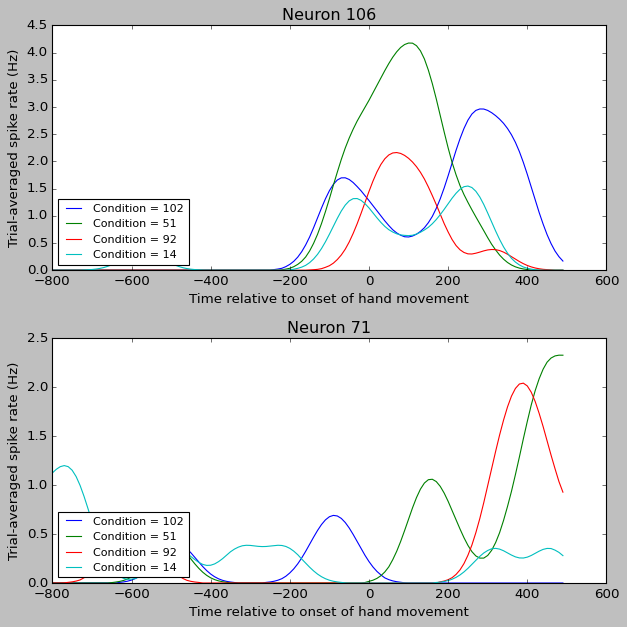

In [1545]:
## Plot pre-distortion
plot_psths(X_seven, times, 2, 1, 4)

In [1546]:
## Distortion
for N in range(X_seven.shape[0]):
    conditions = np.random.choice(108, (108//2,), replace=False)
    X_seven[N, conditions, 65:] = 2*X_seven[N, conditions, 65].reshape((54,1))- X_seven[N, conditions, 65:]

In [1547]:
## Normalising
X_seven_norm = norm_data(X_seven)

(108,)


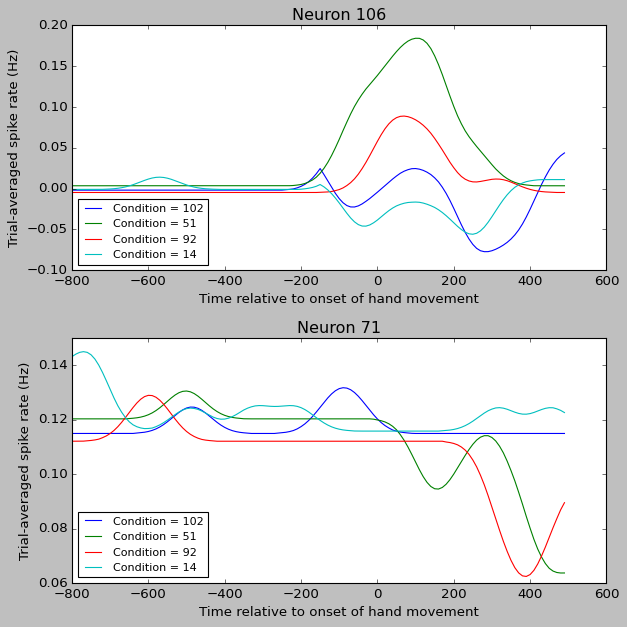

In [1548]:
## Mean centering
X_seven_norm_mean = center_data(X_seven_norm)
plot_psths(X_seven_norm_mean, times, 2, 1, 4)

In [1549]:
## Dimensionality reduction by PCA
X_seven_trunc = X_seven_norm_mean[:, :, 65:111]
X_seven = X_seven_trunc.reshape(X_seven_trunc.shape[0], X_seven_trunc.shape[1] * X_seven_trunc.shape[2])
pca_seven = PCA(n_components=12)
pca_seven.fit(X_seven.T)
Z = pca_seven.transform(X_seven.T).T

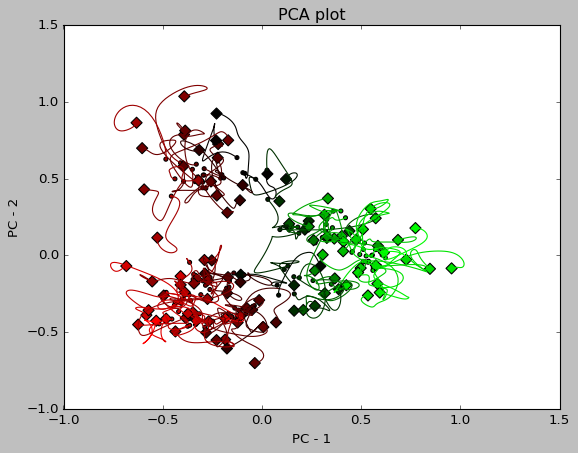

In [1550]:
Z = Z.reshape(12, X_trunc.shape[1], X_trunc.shape[2])
plot_pca_psths(Z, 1, 2)

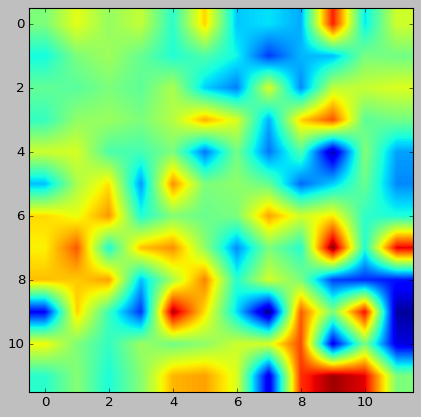

In [1551]:
# Exercise 4
beta, A = a_estimate(Z)
plt.imshow(A)
plt.show()

2.498001805406602e-16


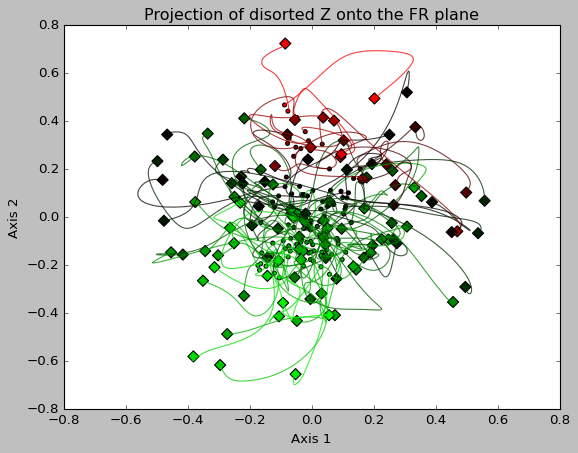

In [1554]:
## A)
A_evalue, A_evector = np.linalg.eig(A)

## B)
P_FR = get_p(A_evector, 0)

## C)
Projection_FR = np.tensordot(P_FR, Z, axes=([1], [0]))
plot_proj_psths(Projection_FR[:, :, 0:36], 'Projection of disorted Z onto the FR plane', alpha=0.75)